# Exploratory Data Analysis (EDA)

## Before Data Cleaning
---

### Libraries imports and Data Loading
Firstly, essential libraries are imported:
- sys
- os
- pandas for tabular datata, 
- numpy for calculations on arrays and vectors, 
- matplotlib for creating graphs, 
- seaborn for more advanced graphs (e.g. heatmap or pairplot),
- and custom functions.

Also `mutual_info_classif` function from sklearn library is imported for mutual information calculation and `LabelEncoder` for encoding categorical data.

In the next step the default style for the charts appearance is set. Then, the dataset for UCI Heart Disease is loaded into a pandas DataFrame. To get initial brief overview of the columns, datatypes and sample values, first 5 rows are displayed.



In [1]:

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from scripts.utils import (
    plot_index_column_relation, 
    print_unique_values,
    plot_pairplot_with_hue,
    plot_class_distribution)

sns.set(style="whitegrid")
%matplotlib inline

df = pd.read_csv("../data/heart.csv")
df.head()


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


From this small sample of the dataset, we can assume that there is unique identifier for each row. Moreover, some imbalance in the dataset is possible - for 5 instances, there are 5 `Males` and only one `Female`. 
However, both thesis require evaluation.

### Dot Sample Method
Dot sample method was used to randomly select a subset of the data. This method is useful due to the fact that the data might have been somehow ordered or grouped, which could lead to biased results if the data were selected in a non-random manner.


In [2]:
df.sample(3, random_state=13)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
565,566,52,Male,Hungary,asymptomatic,130.0,298.0,False,normal,110.0,True,1.0,flat,NaN,NaN,1
497,498,38,Male,Hungary,asymptomatic,110.0,196.0,False,normal,166.0,False,0.0,NaN,NaN,NaN,1
320,321,36,Male,Hungary,non-anginal,112.0,340.0,False,normal,184.0,False,1.0,flat,NaN,normal,0


Once again the number of `Males` dominates over the number of `Females`. In this case ratio of `Males` to `Females` is 3:0. 
Besides this, it can be noticed that even young adults with normal ranges of ECG and blood sugar suffer from heart diseases.
Moreover, significant data is missing for those rows - such as: `ca`, `thal`, `slope` which may suggest that the dataset from Hungary differs in completeness from the one from Cleveland.

### Shape and Size of Dataset


In [3]:
print("Shape:", df.shape)
print("Records (rows):", df.shape[0])
print("Features (columns):", df.shape[1])

Shape: (920, 16)
Records (rows): 920
Features (columns): 16


The most basic information regarding the dataset is its shape. In this case we are dealing with moderate dataset with 16 features (columns) and 920 records (rows).

### Data Types
In this step it is investigated what type of data is used.

In [4]:
df.dtypes

id            int64
age           int64
sex          object
dataset      object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalch      float64
exang        object
oldpeak     float64
slope        object
ca          float64
thal         object
num           int64
dtype: object

There is many categorical features which will later require change into numerical ones. Moreover, there are also unncessary floating point numbers in the data - e.g. `ca` column. As it is a number of major vessels, integer format will be sufficient.

#### Null Values

In [5]:
null_percentage = df.isnull().mean() * 100
print(null_percentage.sort_values(ascending=False))

ca          66.413043
thal        52.826087
slope       33.586957
fbs          9.782609
oldpeak      6.739130
trestbps     6.413043
exang        5.978261
thalch       5.978261
chol         3.260870
restecg      0.217391
cp           0.000000
dataset      0.000000
id           0.000000
age          0.000000
sex          0.000000
num          0.000000
dtype: float64


We can notice that `ca` which stands for `number of major vessels` and `thal` which is `abnormality in heart function` present over 50% of null values.

#### Categorical vs Numerical Columns
Later dataset is checked under the condition of categorical vs numerical data types.

In [6]:
numerical_columns = df.select_dtypes(include=np.number).columns.to_list()
categorical_columns = df.select_dtypes(exclude=np.number).columns.to_list()

print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)


Numerical columns: ['id', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'num']
Categorical columns: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


One can notice that many columns belong to categorical which later require encoding.

##### Statistical Description of Numerical Columns 

In [7]:
df[numerical_columns].describe()

,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


`id`: stands only for the index and it is completely not useful for the data analysis. In the process of cleaning this column can be freely dropped.

`age`: we are dealing with middle-aged adults. At first glance it does not look like we were dealing with any kind of outliers.

`trestbps (resting blood pressure)`: requires data cleaning due to unusually low value.

`chol`: requires data cleaning due to unusually low and high values.

`thalch (maximum heart rate)`: consists of plausible values which may prove to be essential in the estimation of fitness.

`oldpeak (ST depression)`: requires data cleaining due negative = impossible values.

`ca (number of vessels colored)`: significant number of missing values, however important feature for the analysis.

`num (presence of heart disease)`: multiclass format, instead of binary. Requires invsetigation for data imbalance (data skews towards lower classes).

##### Statistical Description of Categorical Columns 

In [8]:
if categorical_columns:
    display(df[categorical_columns].describe())
else:
    print("No categorical columns to describe")

,sex,dataset,cp,fbs,restecg,exang,slope,thal
count,920,920,920,830,918,865,611,434
unique,2,4,4,2,3,2,3,3
top,Male,Cleveland,asymptomatic,False,normal,False,flat,normal
freq,726,304,496,692,551,528,345,196


`sex`: the initial assumption regarding data impalance is met, as the number of males is significantly different than number of females (males constitute 79%).

`dataset`: data comes from different sources, which may result in inconsistent data.

`cp (chest pain type)`: this feature is most likely to be highly predictive for heart diseases. However, most patients do not experience obvious symptoms.

`fbs (fasting blood sugar > 120 mg/d)`: majority has normal sugar levels.

`restecg (resting ECG)`: majority has normal electrocardiogram.

`exang (exercise-induced angina)`: majority does not experience angina during exercise.

`slope (slope of ST segment during excercise)`: flat value is most common. This feature is known to be clinical predictor of ischemia.

`thal (Thallium stress test result)`: many missing values, however clinically significant.

### Index vs Numerical Columns
 

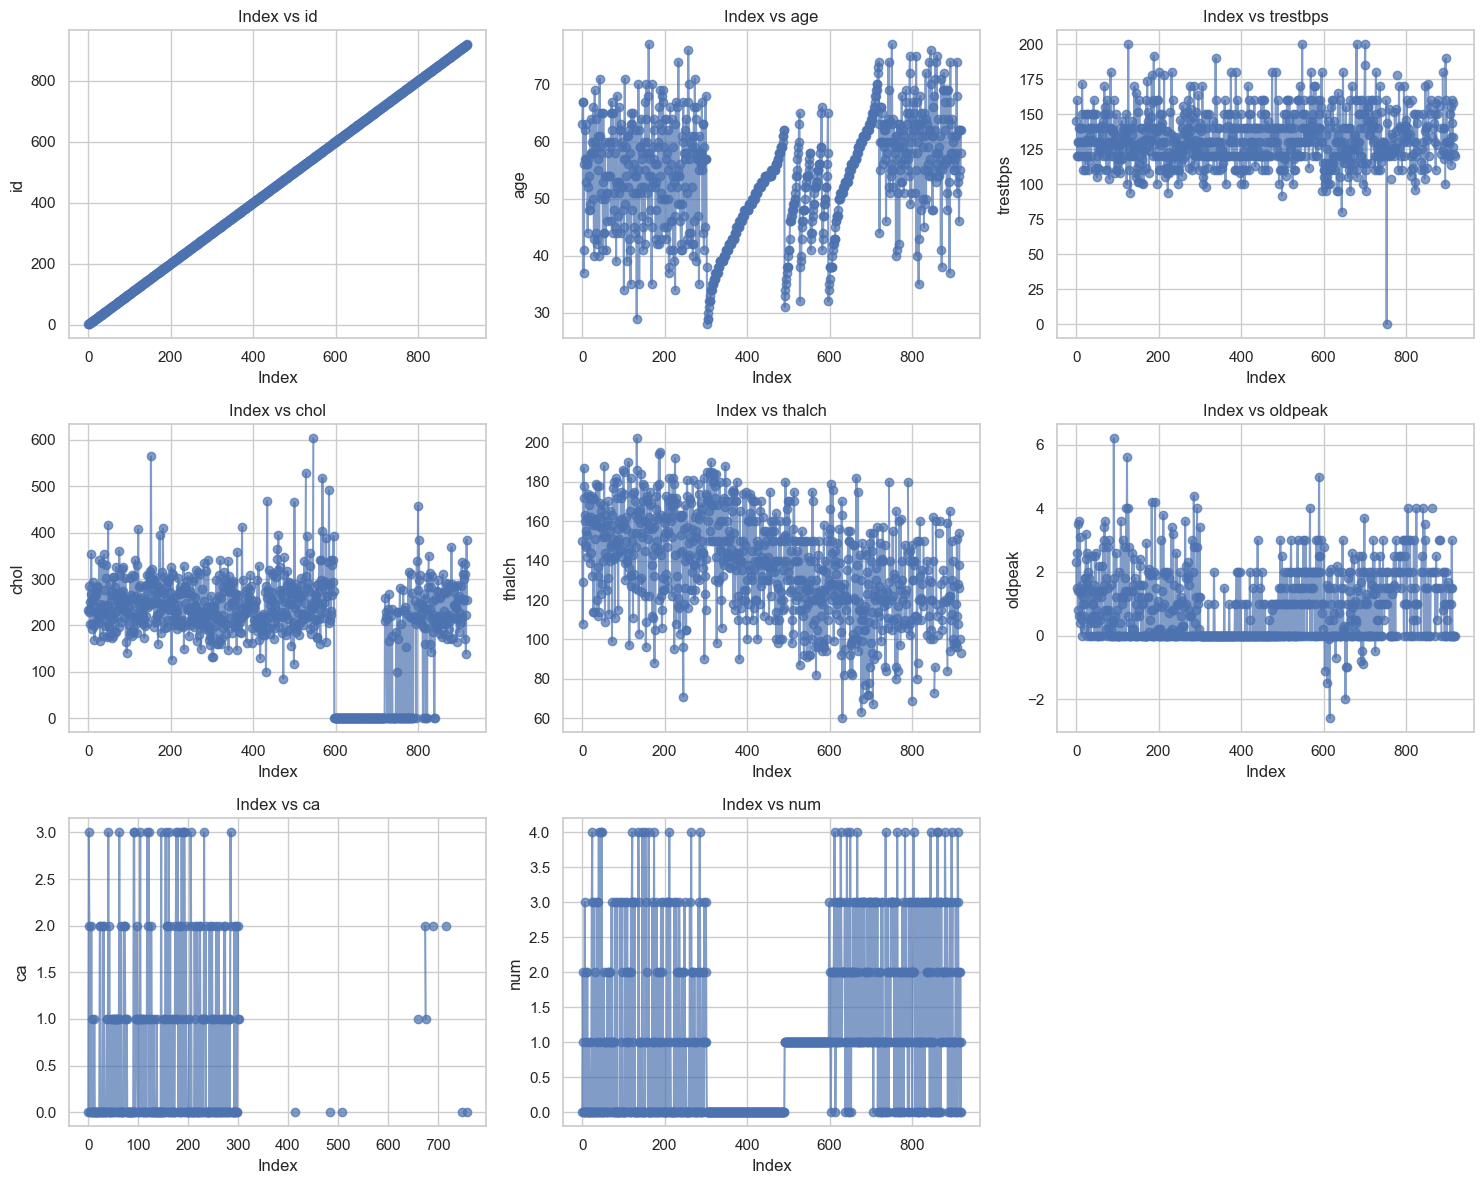

In [9]:
plot_index_column_relation(df)

Plot `Index vs id` confirms that dataset is ordered by `id` and the column will be redundant in data analysis.

An interesting phenomenon may be observed on the plot `Index vs age` where some points appear to be ordered. It may occur due to the fact that dataset consists of smaller datasets from different locations, and for some locations, the data is ordered by `age`. Moreover, some sources has data of younger patients than others.

`Index vs trestbps` indicates some outliers on too low values. Similarly does `Index vs chol` where likely missing values were indicated as 0.

`Index vs oldpeak` presents domination of values in the range between 0 and 3, however, there are some outliers as the oldpeak cannot be below 0.

Many missing rows can be noticed in the plot `Index vs ca`. Range of values is as expected which indicates no outliers.

`Index vs num` indicates that some segments of the data are dominated by a specific class of heart disease label - it can be also due to source of dataset. 

### Histogram Frequency
This plot is used to represent the distribution of data, which shows how often it occurs.

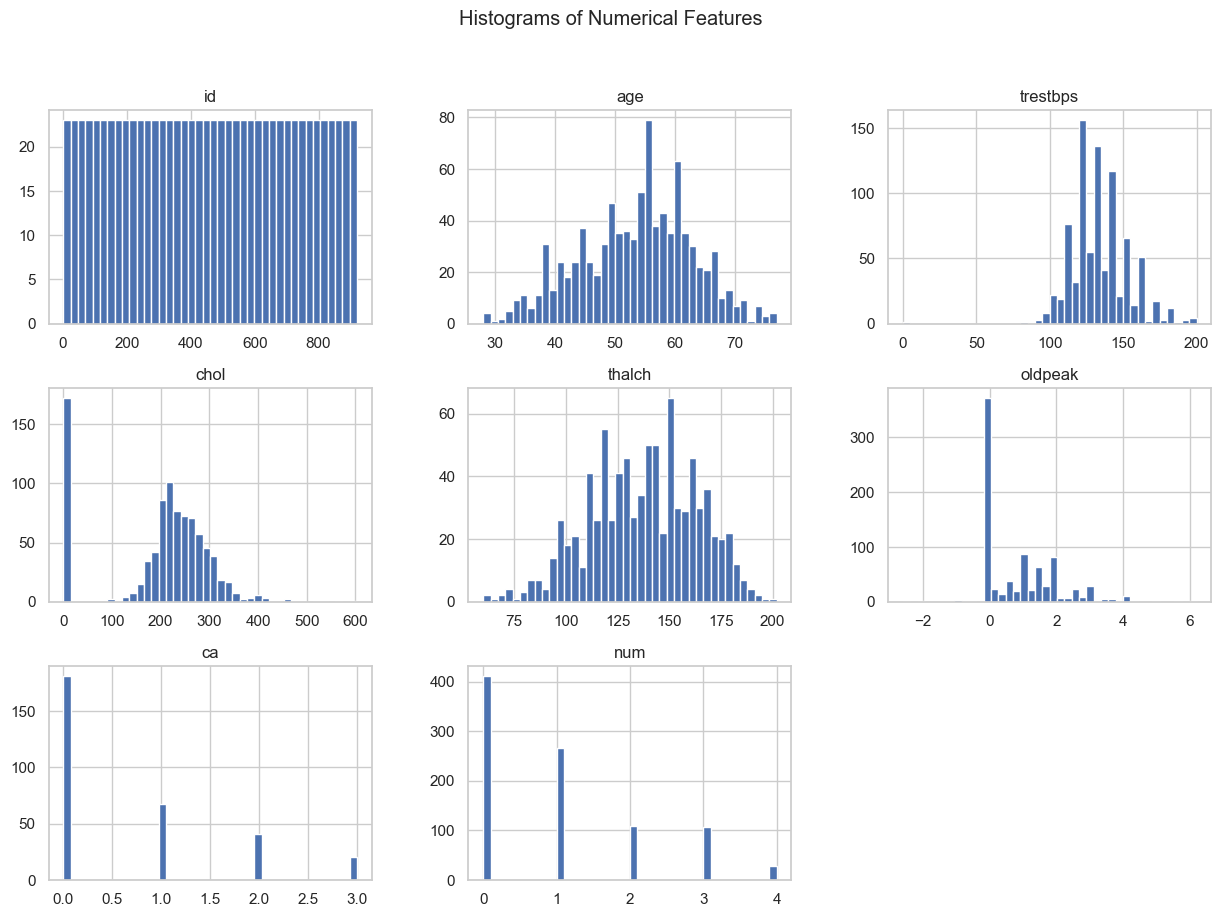

In [10]:

df[numerical_columns].hist(bins=40, figsize=(15, 10))
plt.suptitle("Histograms of Numerical Features")
plt.show()


As expected `id` is uniformly distributed and should not be taken into consideration in data modeling.

Feature `age` roughly shows normal distribution with a peak between 50 and 60. This indicates that the majority of patients are middle-aged or slightly older.

Most values of `trestbps` are between the expected range and the distribution appears to be right-skewed.

With `chol` very specific spike can be noticed at value 0 - which must have been chosen as placeholder for missing values. The remaining values are right-skewed.

The histogram of `thalch` resembles normal distribution with no extreme outliers visible.

`Oldpeak` shows high spike at value 0, which is again a placeholder for missing values, since they are not physiologically possible. 

Number of major vessels colored by fluoroscopy `ca` is represented by discrete values from 0 to 3. The highest concentration is at values 0 and 1 with visible imbalance.

Heart Disease Class - `num` is represented by discrete values from 0 to 4. Most values are concentrated at 0 and 1 with visible imbalance.



### Correlation of Columns
By verifing the correlation, the similarity between the columns can be determined.

#### Correlation Heatmap

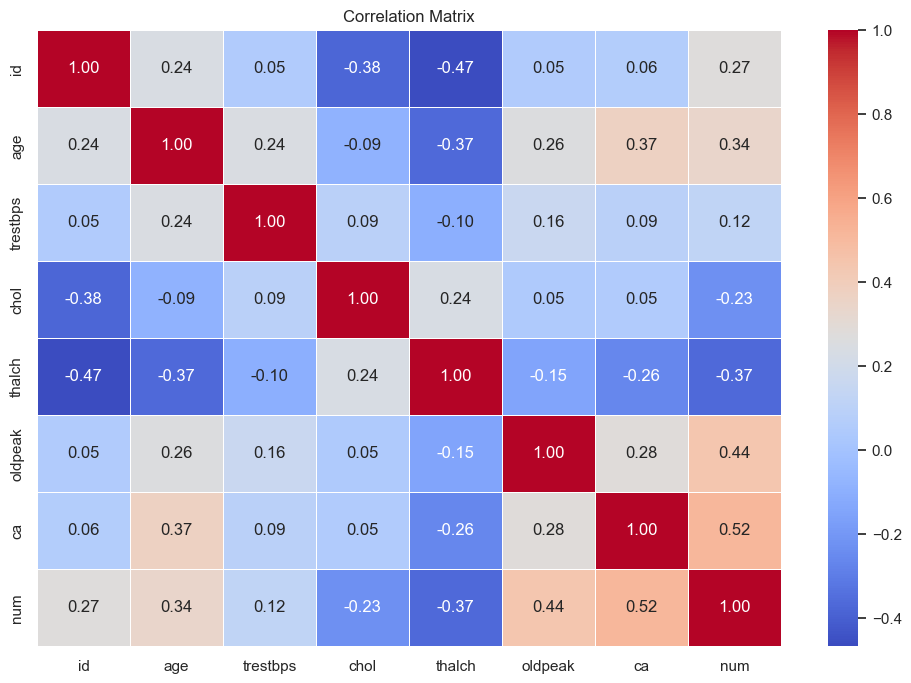

In [11]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_columns].corr(), annot=True, linewidth=.5, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()


| Variable Pair     | Correlation | Strength | Interpretation|
|:-----------------:|:-----------:|:--------:|---------------|
| `num` vs `ca` | +0.52 | Strong positive | The more vessels, the higher likelihood of heart disease.|
| `id` vs `thalach` | -0.47 | Strong negative | ID is just a sequential number. The dataset appears to be ordered by source, so earlier patients (lower id) are younger, they tend to be healthier and are more likely to have higher max heart rate.|
| `num` vs `oldpeak` | +0.44 | Moderate positive | Higher ST depression (`oldpeak`) is connected with likelihood of heart disease.|
| `id` vs `chol` | -0.38 | Moderate negative | Again ID is just index number and the correlation is due to the ordering of the data.|
| `age` vs `ca` | +0.37 | Moderate positive | Elderly patients are more likely to have affected vessels.|
| `age` vs `thalach` | -0.37 | Moderate negative | Older patients tend ot have lower max heart rate.|
| `num` vs `thalach` | -0.37 | Moderate negative | Lower max heart rate increases likelihood of heart disease.|
| `num` vs `age` | +0.34 | Moderate positive | The elderly are at greatest risk of developing heart diseases.|
| `ca` vs `oldpeak` | +0.28 | Weak-to-moderate positive | The greater number of major vesselsm, the higher is the ST depression.|
| `num` vs `id` | +0.27 | Weak positive | ID is not a valid feature and not related to prediction.|
| `age` vs `oldpeak` | +0.26 | Weak positive | Older individuals show slightly higher ST depression.|
| `ca` vs `thalach` | -0.26 | Weak negative | The higher number of vessels, the lower is max heart rate.|


In [12]:
df.corr(numeric_only=True)


,id,age,trestbps,chol,thalch,oldpeak,ca,num
id,1.000000,0.239301,0.052924,-0.376936,-0.466427,0.049930,0.061433,0.273552
age,0.239301,1.000000,0.244253,-0.086234,-0.365778,0.258243,0.370416,0.339596
trestbps,0.052924,0.244253,1.000000,0.092853,-0.104899,0.161908,0.093705,0.122291
chol,-0.376936,-0.086234,0.092853,1.000000,0.236121,0.047734,0.051606,-0.231547
thalch,-0.466427,-0.365778,-0.104899,0.236121,1.000000,-0.151174,-0.264094,-0.366265
oldpeak,0.049930,0.258243,0.161908,0.047734,-0.151174,1.000000,0.281817,0.443084
ca,0.061433,0.370416,0.093705,0.051606,-0.264094,0.281817,1.000000,0.516216
num,0.273552,0.339596,0.122291,-0.231547,-0.366265,0.443084,0.516216,1.000000


From this analysis, following some initial conclusions can be drawn.
- Column `id` can be dropped - it is purely artificial and will not be important in future steps. 
- Number of affected vessels `ca` has the strongest positive correlation with num which indicates it as a critical factor in the prediction of heart diseases.
- Response to excercise is a significant risk indicator - `oldpeak` (ST depression) and `thalach` (max heart rate) are moderately correlated with `num`.
- `Age` correlates positively with `ca`, `oldpeak`, `num`. This indicated that older patients are more likely to have more major vessels, ST depression and heart disease.

### Unique Values

In [13]:
print_unique_values(df)


Column: id
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

Analysis of numerical columns:
- `id`: It confirms again that ID is nothing else than the index of column.
- `age`: Dataset covers a wide range of ages, from 28 to 77 years old with no visible outliers.
- `trestbps`: There is many unique values, however it also includes medically invalid values at 0.0.
- `chol`: Very rich distribution, again it includes invalid values at 0.0.
- `thalch`: High variety, likely continous variable. No outliers.
- `oldpeak`: Includes negative values, which are incorrect for the ST depression metric. 
- `ca`: Discrete number of major vessels. Values in range form 0 to 3.
- `num`: Target class (heart disease severity or presence), values in range from 0 to 4.

Analysis of categorical columns:
- `sex`: Binary encoding 'Male', 'Female', however it could be encoded as 0/1.
- `dataset`: 	Origin of patient record (dataset source).
- `cp`: Categorical feature requiring label encoding.
- `fbs`: Boolean feature for fasting blood sugar (>120mg/dl = true)
- `restecg`: Results of ECG exam in 3 categories.
- `exang`: Boolean values for exercise induced angina.
- `slope`: Slope of ST segment represented by 3 categories.
- `thal`: Thalassemia condition represented by 3 categories.

### Pairplot with Hue

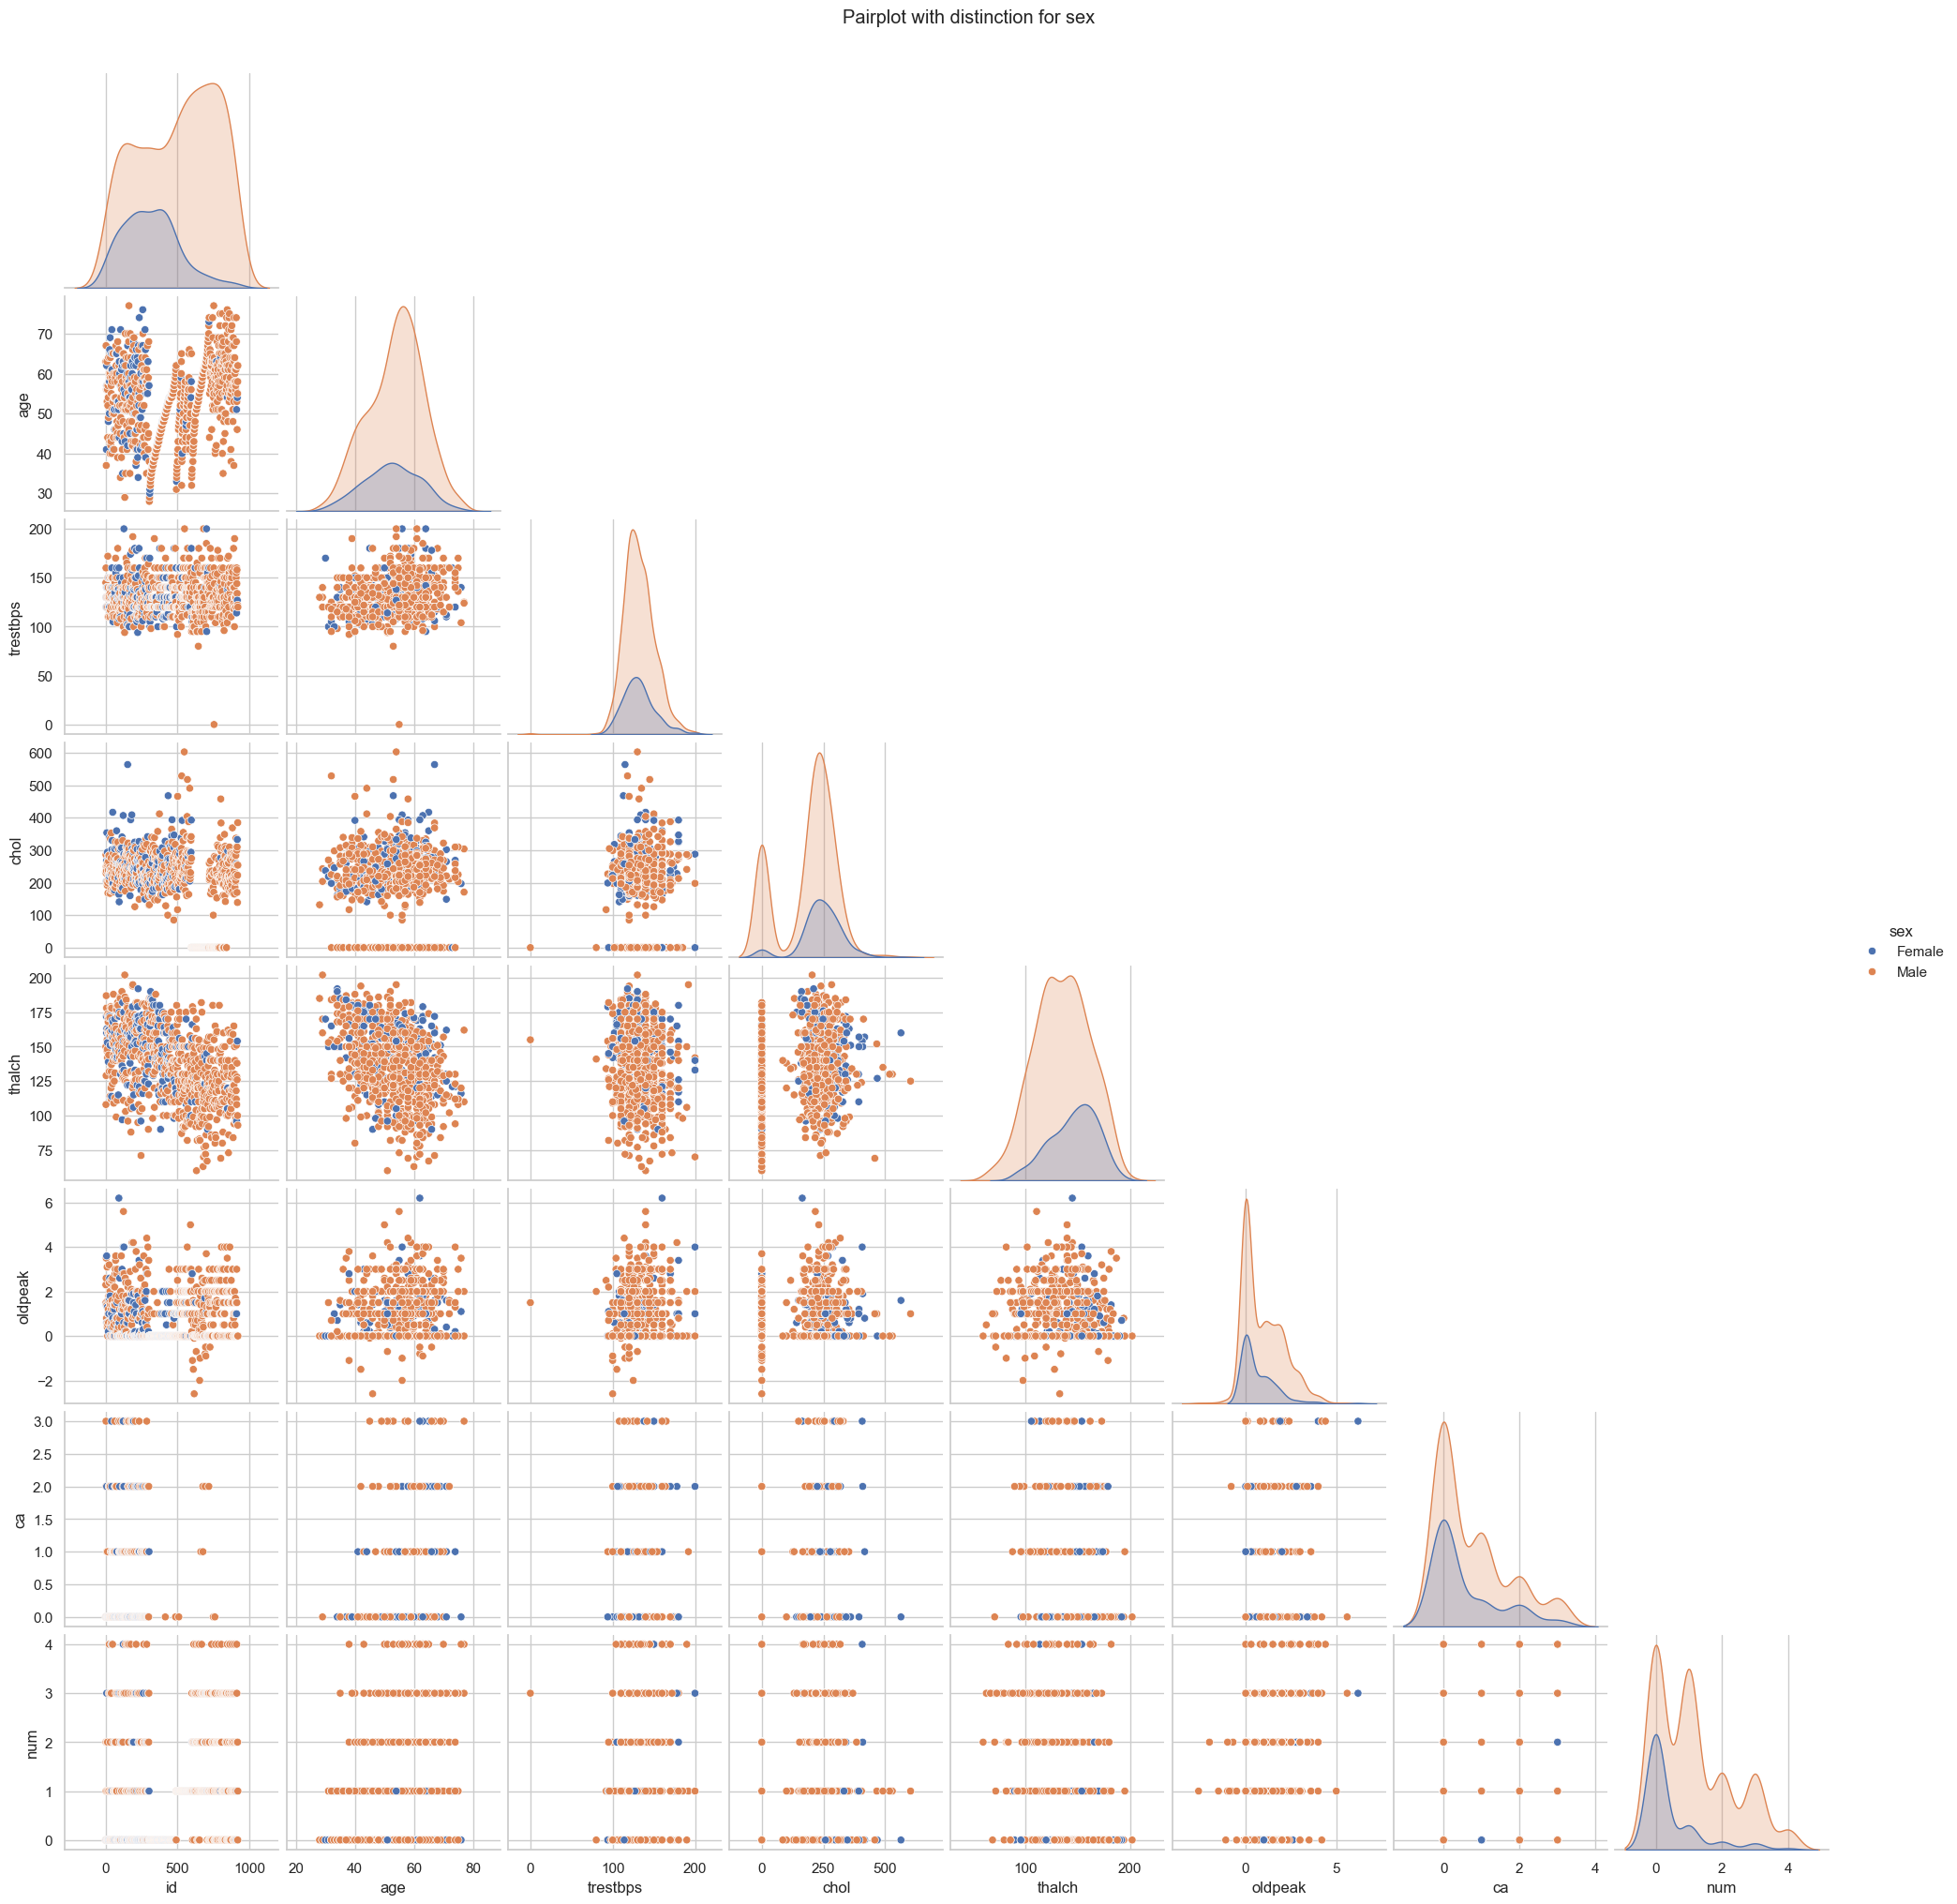

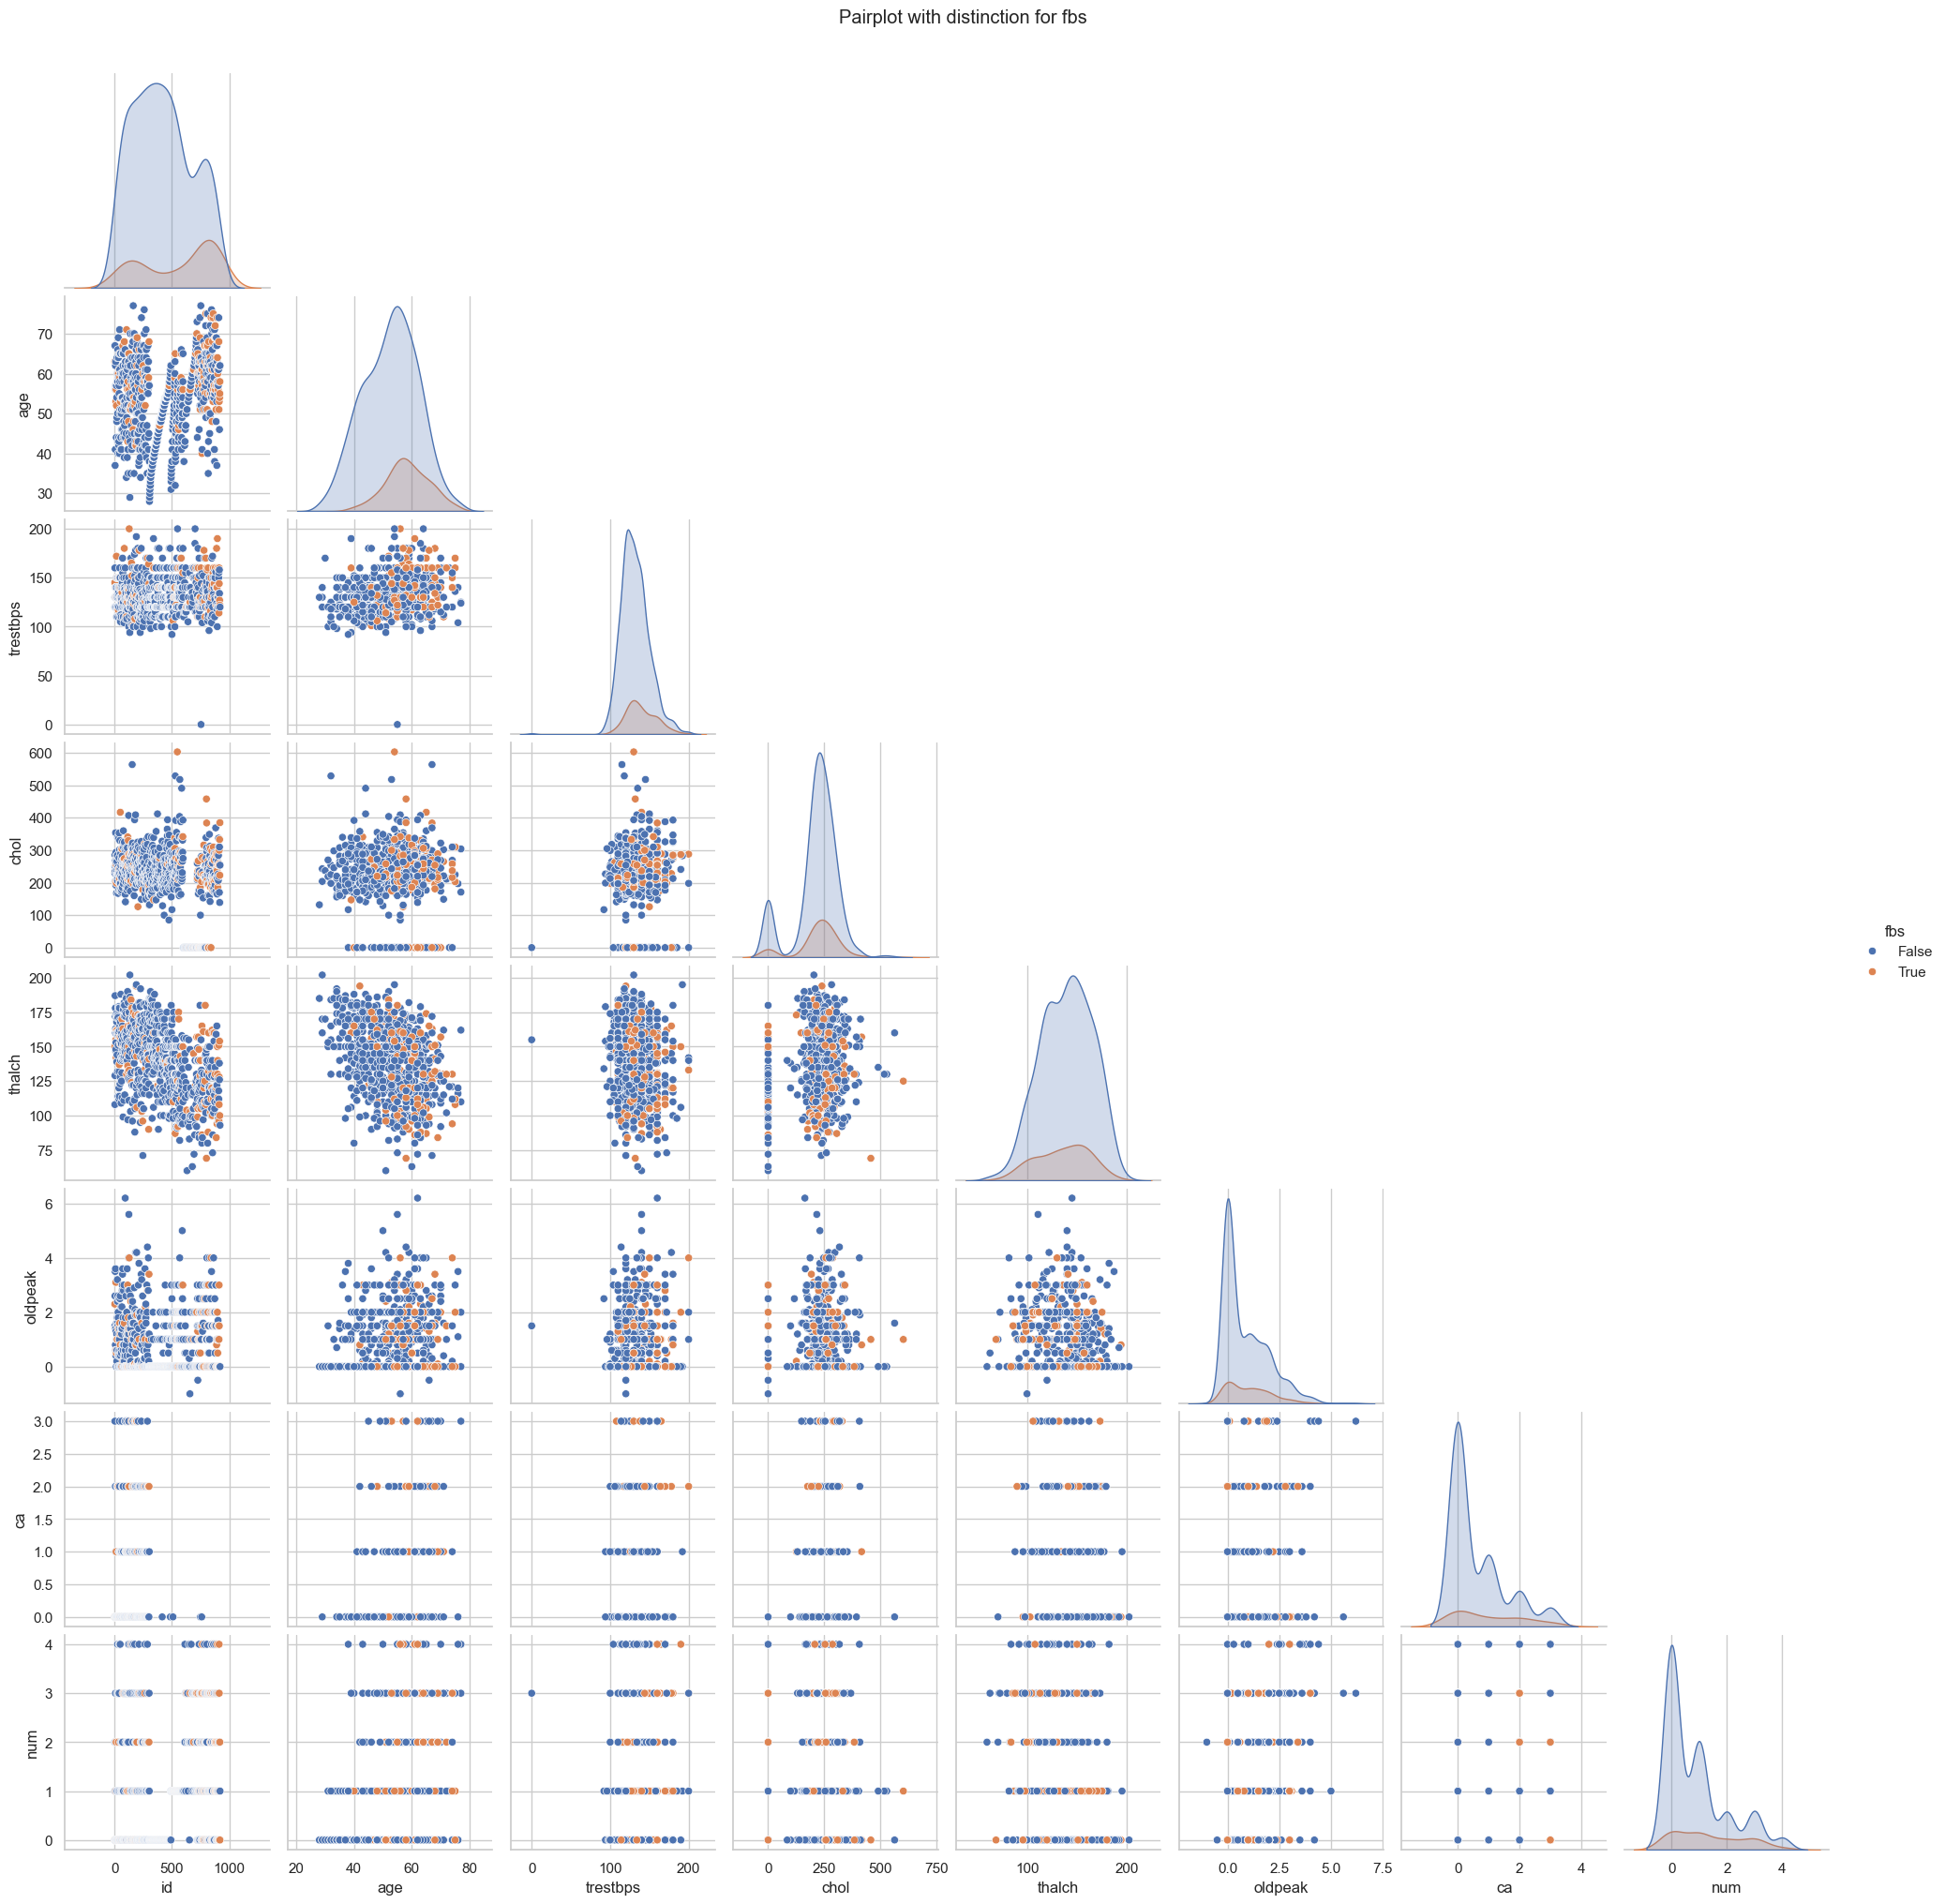

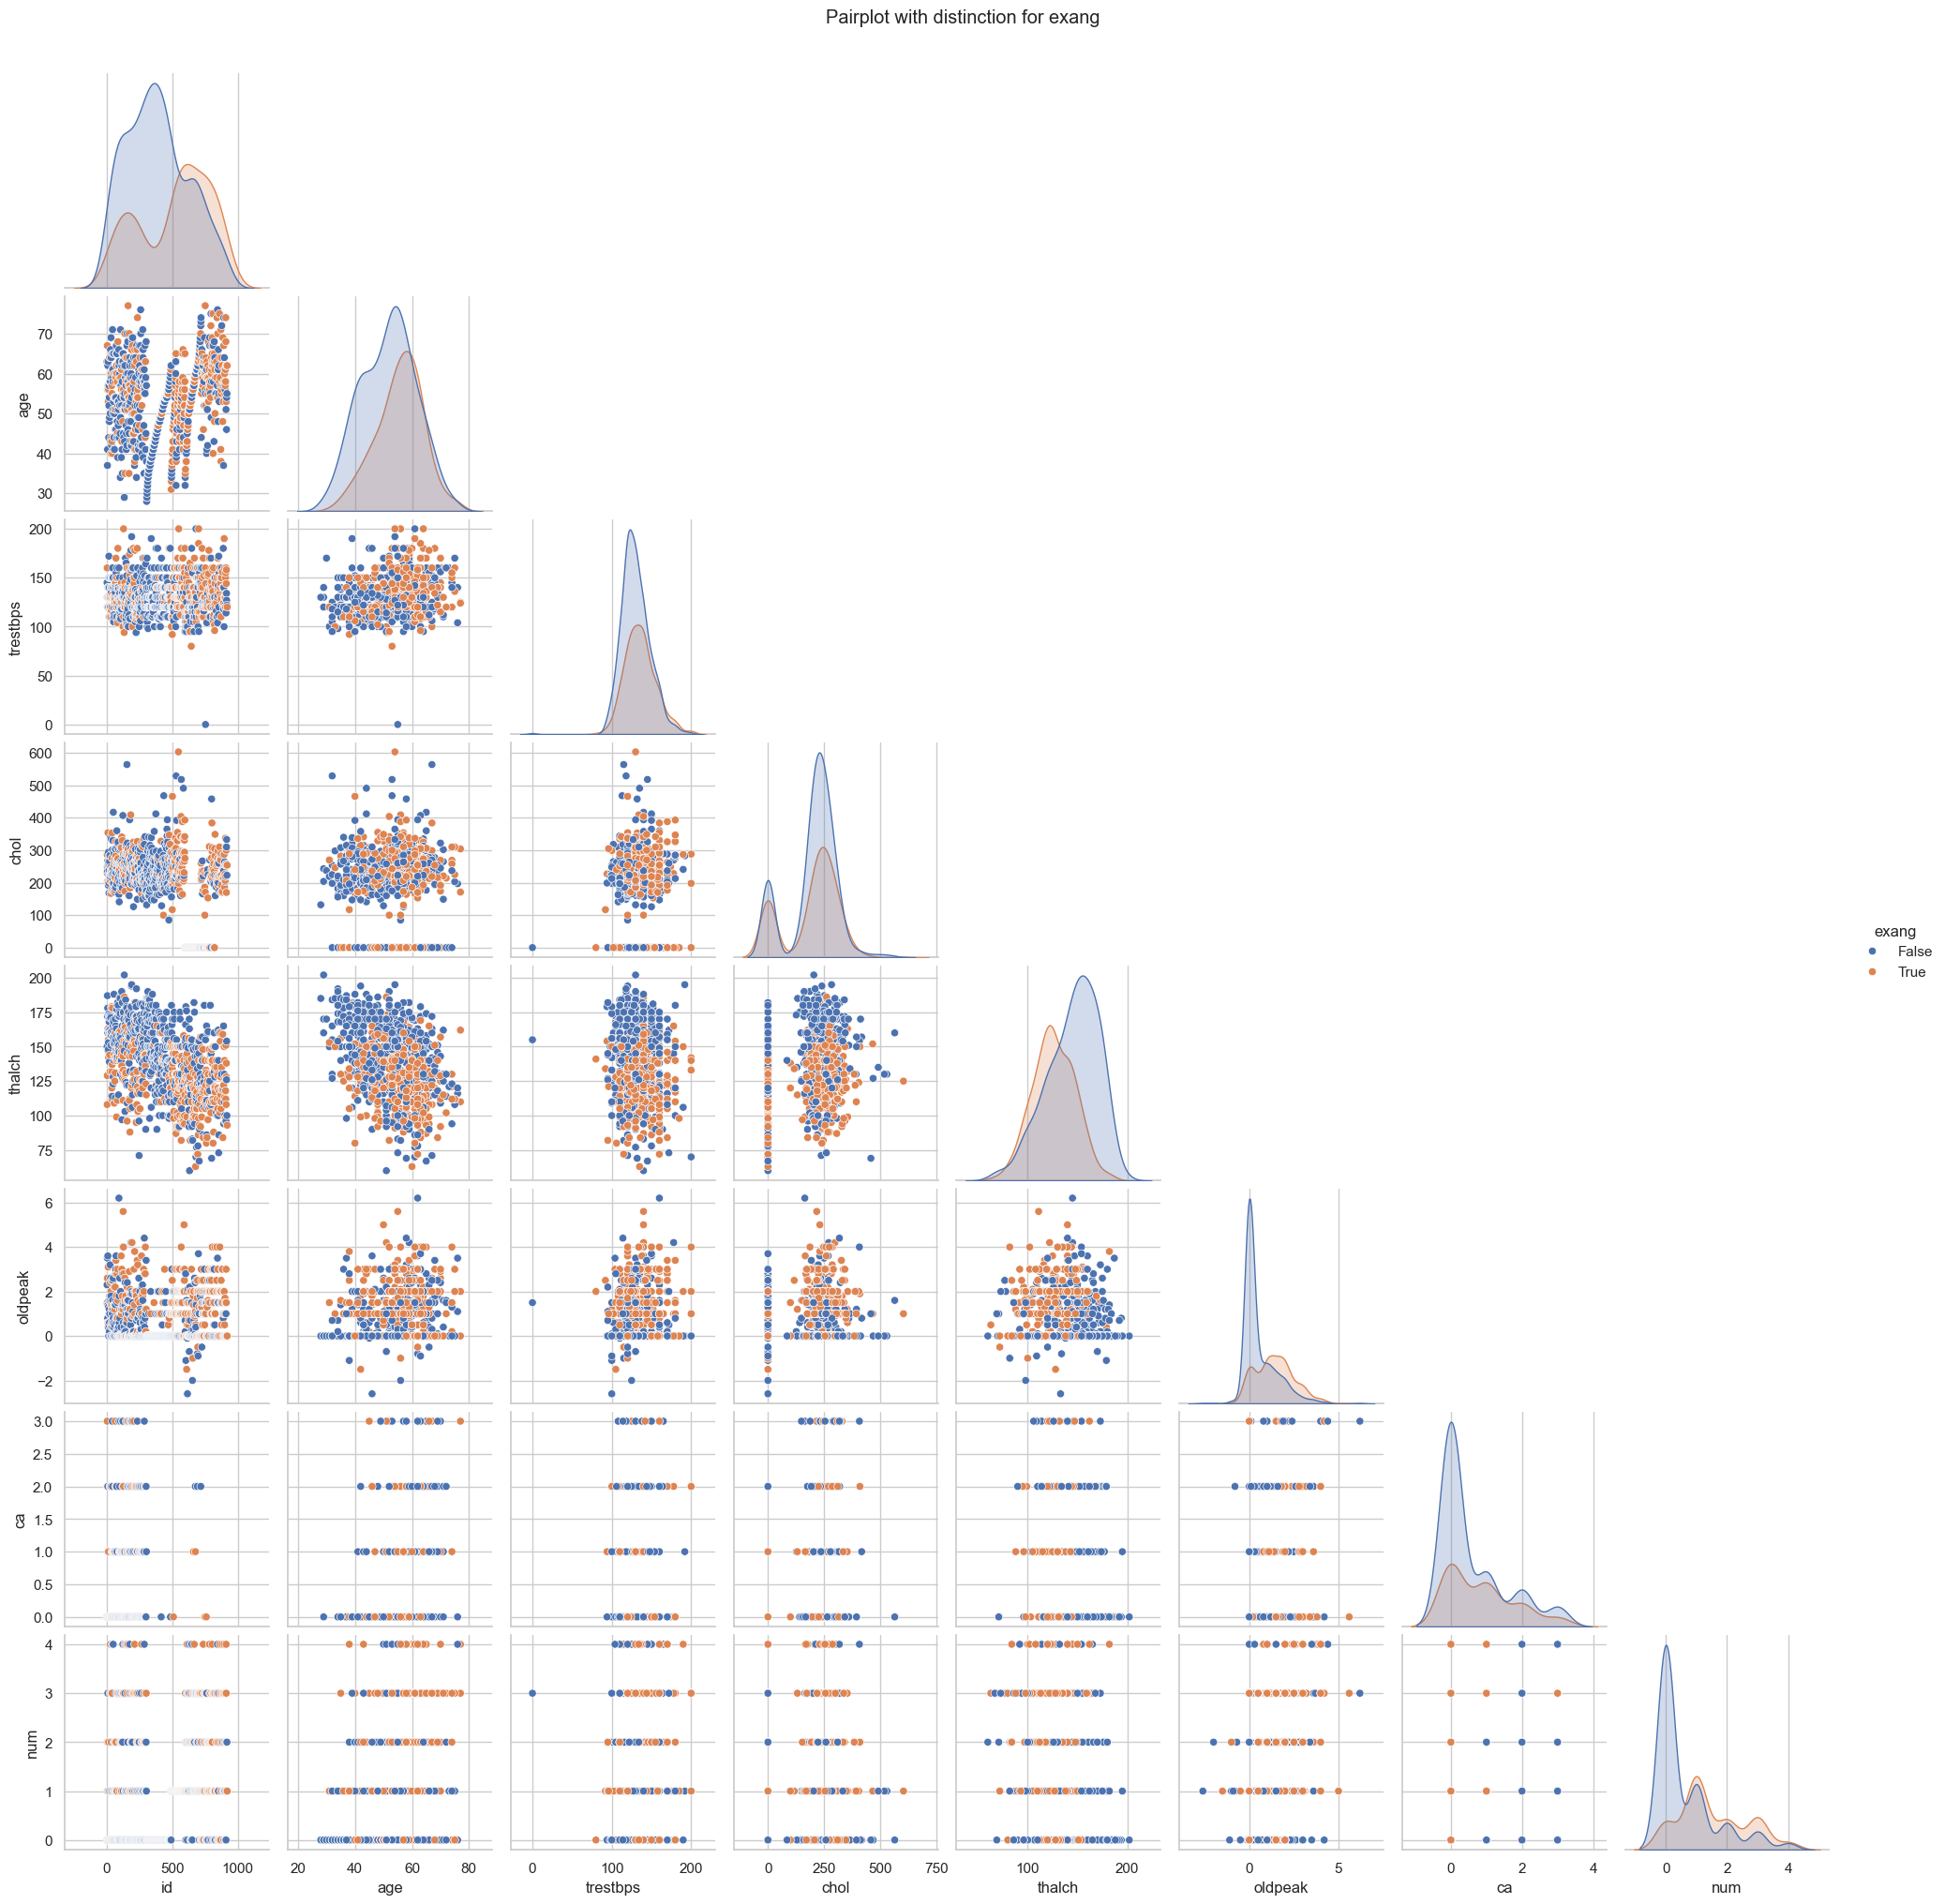

In [14]:
plot_pairplot_with_hue(df, hue_col='sex')
plot_pairplot_with_hue(df, hue_col='fbs')
plot_pairplot_with_hue(df, hue_col='exang')


Pairplot by `sex` does not present any sharp separation between males and females regarding heart disease, however it suggests confirms data imbalance male vs female.

Pairplot by `fbs` indicates very strong imbalance of records with elevated blood sugar levels vs normal  levels. There is no strong visible separation between `trestbps`, `chol`, `thalch`, or `oldpeak` and it doesnt seem to correlate strongly with num.

Pariplot with distinction by `exang` provides us with some more information - `thalch`, `oldpeak`, and `exang` together can be strong predictors of heart disease. Patients without angina tend to reach higher max heart rates.
Moreover, those with angina have higher ST depression. Also, angina is more common in patients with heart disease, have more vessels affected (ca) and are slightly older.

### Class Label Distribiution 

In plots of class label distribution only the categorical columns were considere with discrete numerical with few uniqe values.


Class Distribution Summary for 'sex':
| Class   |   Instances |   Percentage |
|:--------|------------:|-------------:|
| Female  |         194 |        21.09 |
| Male    |         726 |        78.91 |

Class Distribution Summary for 'cp':
| Class           |   Instances |   Percentage |
|:----------------|------------:|-------------:|
| asymptomatic    |         496 |        53.91 |
| atypical angina |         174 |        18.91 |
| non-anginal     |         204 |        22.17 |
| typical angina  |          46 |         5.00 |

Class Distribution Summary for 'fbs':
| Class   |   Instances |   Percentage |
|:--------|------------:|-------------:|
| False   |         692 |        83.37 |
| True    |         138 |        16.63 |

Class Distribution Summary for 'restecg':
| Class            |   Instances |   Percentage |
|:-----------------|------------:|-------------:|
| lv hypertrophy   |         188 |        20.48 |
| normal           |         551 |        60.02 |
| st-t abnormality 

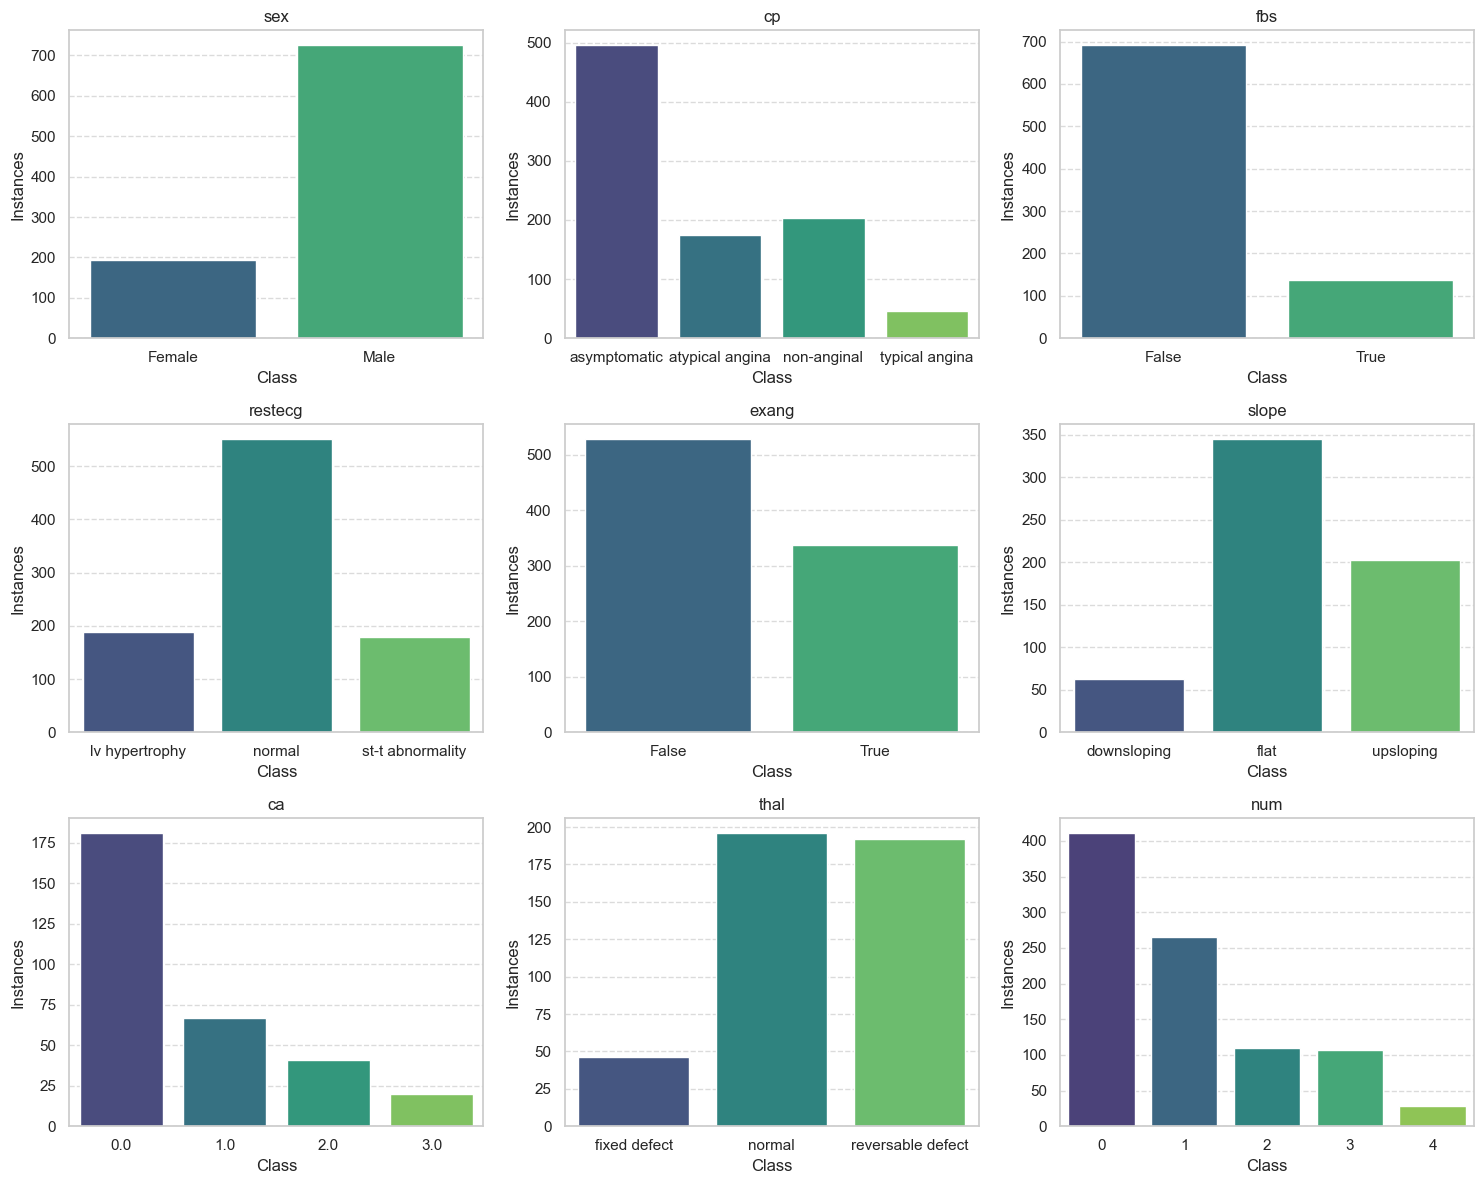

In [17]:
target_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'num']
plot_class_distribution(df, target_cols)